In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import sys
sys.path.insert(0, '../')

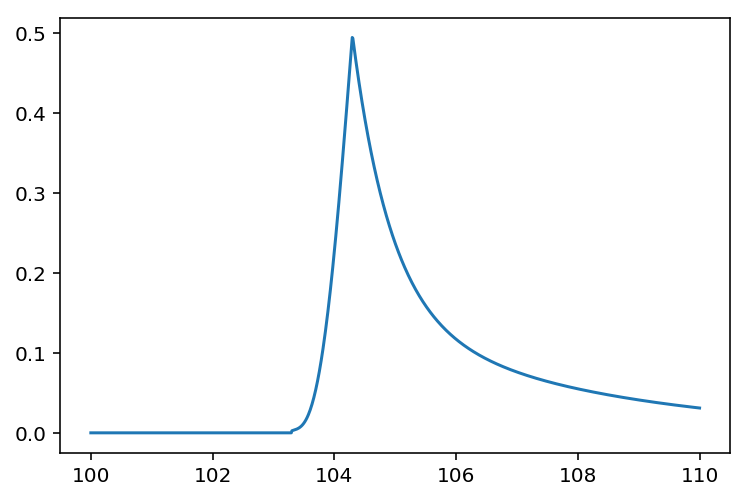

In [4]:
from libra import flare_flux

times = np.linspace(100, 110, 1000)

time_at_peak_flux = 104.3
maximum_flux = 0.5
duration_fwhm = 1

fluxes = flare_flux(times, time_at_peak_flux, maximum_flux, duration_fwhm)

plt.plot(times, fluxes)